In [ ]:
# dev a class to easily do GPR
# a multi-dimensional data set

# setup imports and gen fake data

In [67]:
import numpy as np
import matplotlib

# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

In [68]:
def gen_data(X, Y):
    
    ys = []
    for x0, x1 in zip(X,Y):
#         x0, x1 = x[0], x[1]
        y = x0 * np.sin(x0*10)
        y += x1 * np.sin(x0*10)
        y += 1
#         y += np.random.uniform(0, 0.1)
        ys.append(y)
    return np.array(ys)

In [69]:
# generate some fake data
x = np.linspace(0, 1, 20)
# x = x[::2]
X, Y = np.meshgrid(x, x)

X = X.ravel()
Y = Y.ravel()

z = gen_data(X, Y)

XY = np.column_stack([[X, Y]]).T

In [70]:
z.shape

(400,)

In [21]:
XY.shape

(400, 2)

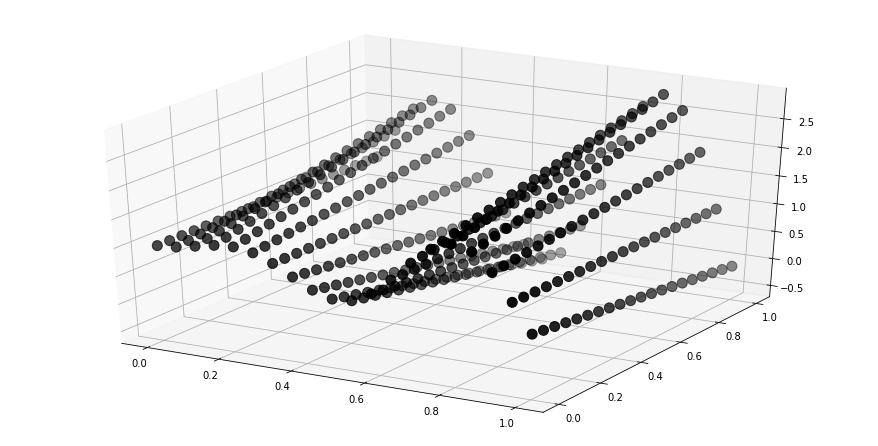

In [22]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(XY[:,0], XY[:,1], z, s=100, c='k')

In [23]:
# validation data
# generate some fake data
xval = np.linspace(0, 1, 40)
Xval, Yval = np.meshgrid(xval, xval)
# x = x[::6]

Xval = Xval.ravel()
Yval = Yval.ravel()

zval = gen_data(Xval, Yval)

XYval = np.column_stack([[Xval, Yval]]).T

# class dev

In [24]:
import george
george.__version__
from george import kernels

import scipy.optimize as op

In [25]:

class GPRFit(object):
    def __init__(self, X, Y, yerr=None):
        """
        X : np.ndarray, shape = (N, D), N=samples, D=dimension
        Y : np.ndarray, shape = (N,)
        yerr : np.ndarray, shape = (N,)
        """
        self.X = X
        self.Y = Y
        self.yerr = yerr
        if self.yerr is None:
            print("no yerr given - setting to zero")
            self.yerr = np.zeros(shape=self.Y.shape)
            
        
    def setup_kernel(self, kernel):
        self.kernel = kernel
        
    def fit(self):
        self.gp = george.GP(self.kernel)
        self.gp.compute(self.X, self.yerr)
        
    def opt(self):
        # Define the objective function (negative log-likelihood in this case).
        def nll(p):
            self.gp.set_parameter_vector(p)
            ll = self.gp.log_likelihood(self.Y, quiet=True)
            return -ll if np.isfinite(ll) else 1e25

        # And the gradient of the objective function.
        def grad_nll(p):
            self.gp.set_parameter_vector(p)
            return -self.gp.grad_log_likelihood(self.Y, quiet=True)

        # You need to compute the GP once before starting the optimization.
        self.gp.compute(self.X, self.yerr)

        # Print the initial ln-likelihood.
        print(self.gp.log_likelihood(self.Y))

        # Run the optimization routine.
        p0 = self.gp.get_parameter_vector()
        results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

        # Update the kernel and print the final log-likelihood.
        self.gp.set_parameter_vector(results.x)
        print(self.gp.log_likelihood(self.Y))
        
    def predict(self, X):
        mean, var = self.gp.predict(self.Y, X)
        return mean, var

In [26]:
gprfit = GPRFit(XY, z)

no yerr given - setting to zero


In [27]:
kernel = np.var(z) * kernels.ExpSquaredKernel(0.5, ndim=2, axes=0)
kernel *= kernels.ExpSquaredKernel(0.5, ndim=2, axes=1)

In [28]:
gprfit.setup_kernel(kernel=kernel)

In [29]:
gprfit.fit()

In [30]:
mean, var = gprfit.predict(XY)

In [31]:
np.linalg.norm(mean-z)

0.023063797753178298

In [32]:
val_mean, val_var = gprfit.predict(XYval)

In [33]:
np.linalg.norm(val_mean-zval)

0.05046527991339977

In [34]:
gprfit.opt()

-683448167.7347261
4559.726095254822


In [35]:
mean, var = gprfit.predict(XY)

In [36]:
np.linalg.norm(mean-z)

1.444215716292283e-06

In [37]:
val_mean, val_var = gprfit.predict(XYval)

In [38]:
np.linalg.norm(val_mean-zval)

9.25022599693904e-06

# try 3d data

In [47]:
def gen_data_3d(X, Y, Z):
    
    ys = []
    for x0, x1, x2 in zip(X,Y,Z):
#         x0, x1 = x[0], x[1]
        y = x0 * np.sin(x0*10)
        y += x1 * np.sin(x0*10)
        y += x2 * np.sin(x0*10)
        y += 1
#         y += np.random.uniform(0, 0.1)
        ys.append(y)
    return np.array(ys)

In [48]:
# generate some fake data
x = np.linspace(0, 1, 10)
# x = x[::2]
X, Y, Z = np.meshgrid(x, x, x)

X = X.ravel()
Y = Y.ravel()
Z = Z.ravel()

z = gen_data_3d(X, Y, Z)

XYZ = np.column_stack([[X, Y, Z]]).T

In [49]:
z.shape

(1000,)

In [50]:
XYZ.shape

(1000, 3)

In [51]:
# validation data
# generate some fake data

xyz = []
for x0 in np.random.uniform(0, 1, 10):
    for x1 in np.random.uniform(0, 1, 10):
        for x2 in np.random.uniform(0, 1, 10):
            xyz.append([x0,x1,x2])
xyz = np.array(xyz)
            




# Xval, Yval, Zval = np.meshgrid(xval, xval, xval)
# # x = x[::6]

# Xval = Xval.ravel()
# Yval = Yval.ravel()
# Zval = Zval.ravel()

# zval = gen_data_3d(Xval, Yval, Zval)
zval = gen_data_3d(xyz[:,0], xyz[:,1], xyz[:,2])

# XYZval = np.column_stack([[Xval, Yval, Zval]]).T

# print(XYZval.shape)

In [52]:
xyz.shape

(1000, 3)

In [53]:
yerr = np.zeros(z.shape) + 1e-4
gprfit = GPRFit(XYZ, z, yerr=yerr)

In [54]:
kernel = np.var(z) * kernels.ExpSquaredKernel(0.5, ndim=3, axes=0)
kernel *= kernels.ExpSquaredKernel(0.5, ndim=3, axes=1)
kernel *= kernels.ExpSquaredKernel(0.5, ndim=3, axes=2)

In [55]:
gprfit.setup_kernel(kernel=kernel)

In [56]:
gprfit.fit()

In [57]:
mean, var = gprfit.predict(XYZ)

In [58]:
np.linalg.norm(mean-z)

0.5307819132295354

In [59]:
# val_mean, val_var = gprfit.predict(XYZval)
val_mean, val_var = gprfit.predict(xyz)

In [60]:
np.linalg.norm(val_mean-zval)

0.5669749867044704

In [61]:
gprfit.opt()

-26032728.390545256
7872.669109594756


In [62]:
mean, var = gprfit.predict(XYZ)

In [63]:
np.linalg.norm(mean-z)

2.746484883822128e-06

In [64]:
# val_mean, val_var = gprfit.predict(XYZval)
val_mean, val_var = gprfit.predict(xyz)

In [65]:
np.linalg.norm(val_mean-zval)

0.29518799183434247

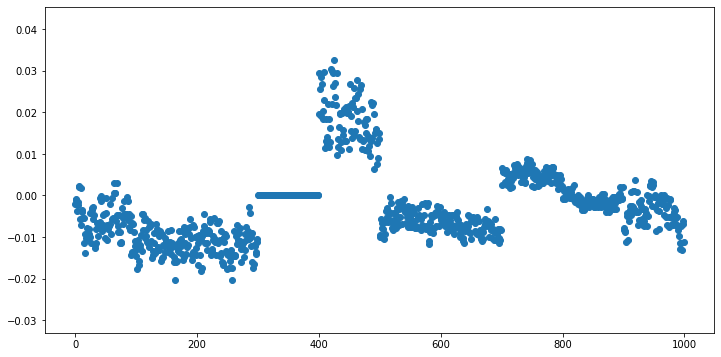

In [66]:
plt.figure()
plt.scatter(range(len(zval)), val_mean - zval)